<hr> 

## Bauxitbetonos épületek Budapesten
### Az ÉMI adatok forrása elérhető [itt](https://www.emi.hu/EMI/web.nsf/Pub/bauxitbeton_epuletek.html)

<hr>  

A bauxitbeton kötőanyagát, az alumíniumcementet főleg az 1920-as eleje és 1940-es évek vége között használták Magyarországon, mivel alkalmazása meggyorsította és gazdaságossá tette a munkát (a hagyományos portlandcementtel készítettel ellentétben egy-két nap alatt megszilárdult). Az 1930-as évektől 1942-ig - főleg Budapesten - igen sok lakó-, köz-, és ipari épület készült bauxitbeton alkalmazásával. A háború alatt védműveket, bunkereket építettek belőle, a negyvenes évek végén pedig sűrűn használták a háborús károk helyreállítására.

Az 1960-as évek végére egyértelművé vált, hogy a megszilárdulás után sajátos kémiai reakciók indulnak meg a bauxitbeton anyagában és ezek szilárdságcsökkenéshez vezetnek. A több mint harmincéves vizsgálati tapasztalat alapján megállapítható, hogy a szilárdságcsökkenés sebessége a korábban feltételezettnél kisebb, de nem elhanyagolható mértékű. A tényleges helyzetet tovább ronthatják olyan kedvezőtlen környezeti hatások, mint a nedvesség és a magas hőmérséklet. Figyelembe kell venni azt a tényt is, hogy a bauxitbeton eleve kisebb szilárdságú, mint a portland cement felhasználásával készült beton. Ezért szükséges a bauxitbeton szerkezetek rendszeres és szakszerű megfigyelése, valamint időszakos műszeres vizsgálata.

ÉMI prezentáció: [BAUXITBETON A HÁZBAN? MÍTOSZ ÉS VALÓSÁG...](https://www.emi.hu/webadatbazisok/Publikaciok.nsf/PublicationsPreviewHTMLByDate/42B00B8C4B3206F8C12580FF00551092/$FILE/Bauxitbeton%20a%20hazban%20-%20Mitosz%20es%20valosag%20_%20Horvath_Soma.pdf)

In [1]:
from pathlib import Path
import re
import time

import folium
import geocoder
import numpy as np
import pandas as pd
import requests

from bs4 import BeautifulSoup

OUT_DIR = Path("/media/xunguist/FÉLTERRA/Projektek/Python_projektek/BauxitBeton Térkép")

### Adatok letöltése az [ÉMI](https://www.emi.hu/EMI/web.nsf/Pub/bauxitbeton_epuletek.html) oldaláról

In [2]:
url = "https://www.emi.hu/EMI/web.nsf/Pub/bauxitbeton_epuletek.html"
req = requests.get(url)
content = req.text

### Adattáblába rendezés

In [3]:
soup = BeautifulSoup(content, 'html.parser')
items = soup.find_all(class_="talalat")

df = pd.DataFrame()

for element in items:
    item_dict = {}
    item_dict["title"] = element.find(class_="title").get_text()
    item_dict["address"] = element.find(class_="address").get_text()
    item_dict["description"] = element.find(class_="description").get_text()
    item_dict["kapcsolodohivatkozasok"] = \
    element.find(class_="kapcsolodohivatkozasok").get_text()
    item_dict["dokumentumlista"] = \
    element.find(class_="dokumentumlista").get_text()
    
    row_series = pd.Series(item_dict)
    df = df.append(row_series, ignore_index=True)
    
df.replace("",np.nan, inplace=True)
df.isna().sum()

address                      0
description                 59
dokumentumlista           1913
kapcsolodohivatkozasok    1913
title                        0
dtype: int64

### Formázás és tisztítás 

In [4]:
def to_int(text:str):
    if text:
        try:
            ev = int(text)
            return ev
        except ValueError:
            return np.nan
    else:
        return np.nan

In [5]:
bp_bauxit_df = df[df["address"].str.contains("Budapest")].copy()

#split, replace
bp_bauxit_df["description"].fillna("-", inplace=True)
bp_bauxit_df.loc[:,"address"].replace("\n","", inplace=True)
bp_bauxit_df["address_2"] = bp_bauxit_df["address"]\
.str.split(",", expand=True).iloc[:,1:2].copy()
bp_bauxit_df[["ID1","építési év"]] = bp_bauxit_df["title"]\
.str.split(".", expand=True).iloc[:,0:2].copy()
bp_bauxit_df["Kerület"] = bp_bauxit_df["ID1"]\
.str.split("-", expand=True).iloc[:,0].copy()
bp_bauxit_df["Kerület"] = bp_bauxit_df["Kerület"]\
.str.split("/", expand=True).iloc[:,0].copy()
bp_bauxit_df["address_2"] = bp_bauxit_df["address_2"]\
.str.split(".", expand=True).iloc[:,0].copy()
bp_bauxit_df[["ID2","építési_év"]] = bp_bauxit_df["title"]\
.str.split("[",expand=True)
bp_bauxit_df["építési_év"].replace("]","",inplace=True, regex=True)
bp_bauxit_df["építési_év"] = bp_bauxit_df["építési_év"].apply(to_int)
bp_bauxit_df["description"] = bp_bauxit_df["description"]\
.str.replace("::"," ").copy()
bp_bauxit_df["Kerület"].replace({"\(":""}, inplace=True, regex=True)

#elírások és névváltozások javítása
bp_bauxit_df["address_2"].replace({"Mátrai utca": "Mátray utca",
                           "Felvinczi út": "Felvinci út",
                           "Hermann Ottó": "Herman Ottó",
                           "Spáhi utca": "Szpáhi utca",
                           "Homokos dűlő": "Gázgyár Utca",
                           "Pálffy György utca": "Balaton utca",
                           "Nagydiófa utca": "Nagy Diófa utca",
                           "Kisfuvaros utca": "Kis Fuvaros utca",
                           "Nagyfuvaros utca": "Nagy Fuvaros utca",
                           "Lónyai utca": "Lónyay utca",
                           "Budapest, Budafoki út (107)-111-113.": "Budafoki út 111-113.",
                           "Tass vezér utca": "Tas vezér utca",
                           "Acsádi Ignác utca": "Acsády Ignác utca",
                           "Határőr utca": "Határőr út",
                           "Kékgolyó utca": "Kék Golyó utca",
                           "Melinda utca": "Melinda út",
                           "Rege utca": "Rege út",
                           "Rozsnyai utca": "Rozsnyay utca",
                           "Jurisics Miklós": "Jurisich Miklós",
                           "Miskolci út": "Miskolci utca"},
                                  inplace=True,
                                  regex=True)

### Ábrázolás diagrammon kerület szerint

In [6]:
kerulet_df = bp_bauxit_df.groupby("Kerület").count()\
[["address"]].sort_values(by="address", ascending=False)

kerulet_df

,address
Kerület,
II,257
XIII,228
XI,201
XIV,177
XII,163
I,90
IX,79
V,69
VII,64


<AxesSubplot:title={'center':'Bauxitbetonos épületek Budapesten kerület szerint'}, xlabel='Kerület'>

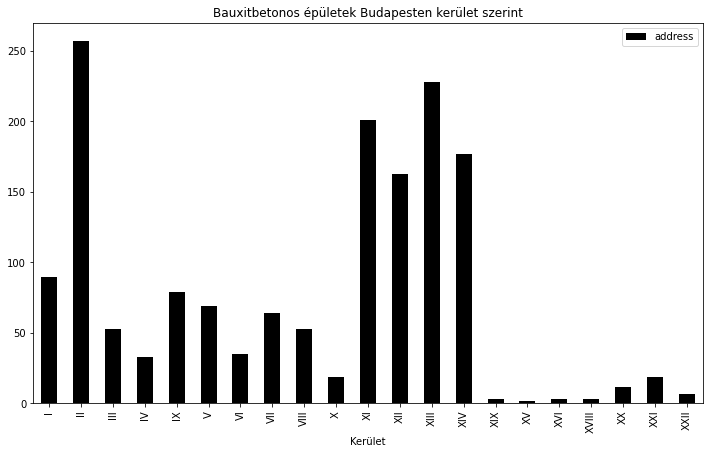

In [7]:
kerulet_df.sort_index(inplace=True)
kerulet_df.plot(kind="bar",
                figsize=(12,7),
                colormap="gist_gray",
                title="Bauxitbetonos épületek Budapesten kerület szerint"
                )

### Ábrázolás diagrammon építési év alapján

In [8]:
epitesi_ev = bp_bauxit_df.groupby("építési_év").count()[["address"]]
epitesi_ev.index = epitesi_ev.index.astype(int)
epitesi_ev.sort_index()

,address
építési_év,
1897,1
1926,2
1928,5
1929,12
1930,30
1931,36
1932,53
1933,34
1934,49


<AxesSubplot:title={'center':'Bauxitbetonos épületek Budapesten építési év szerint'}, xlabel='építési_év'>

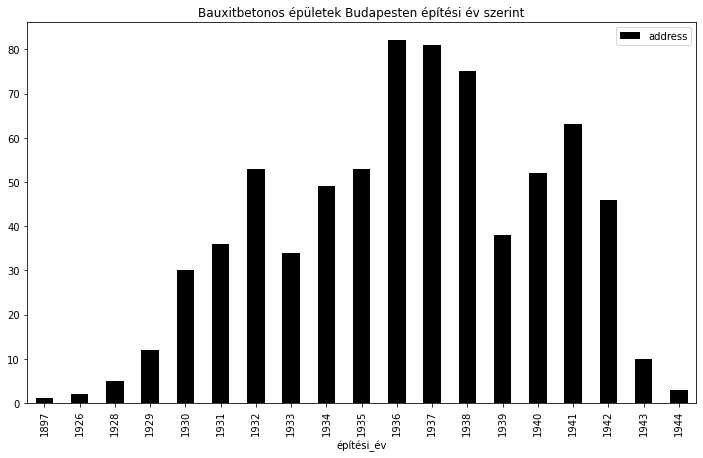

In [9]:
epitesi_ev.plot(kind="bar",
                figsize=(12,7),
                colormap="gist_gray",
                title="Bauxitbetonos épületek Budapesten építési év szerint")

### Koordináták lekérezése cím alapján

#### Open Street Map Policy: 
>No heavy uses (an absolute maximum of 1 request per second).  
OSM’s Nominatim service is mainly there to power the search bar on openstreetmap.org. We are in principle   happy for the public API to be used by external users for creative and unexpected uses.   
<b>However, be aware that the service runs on donated servers and has a very limited capacity.</b>   
We therefore ask you to limit your use and adhere to this usage policy.  
Use of any OSMF provided service is further governed by the OSMF Terms of Use .

In [10]:
def addr_to_coord(address:str)->tuple:
    time.sleep(2)
    if address:
        address = str(address).strip()
        address = address.replace("/","")
        address = "".join(["Budapest, ",address,"."])
    g = geocoder.osm(address)
    try:
        address_coordinate = (g.json.get("lat"), g.json.get("lng"))
        return address_coordinate
    except AttributeError as AE:
        print(address)
        return np.nan

In [11]:
bp_bauxit_df.loc[:,"coordinate"] = bp_bauxit_df["address_2"].apply(addr_to_coord).copy()

None
Budapest, Budafoki út (107)-111-113.


Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Budapest%2C+Sz%C3%BCret+utca+25.&format=jsonv2&addressdetails=1&limit=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f73d7565190>: Failed to establish a new connection: [Errno 101] Network is unreachable'))


Budapest, Szüret utca 25.


Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Budapest%2C+Sz%C3%BCret+utca+5-7.&format=jsonv2&addressdetails=1&limit=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f73d7562590>: Failed to establish a new connection: [Errno 101] Network is unreachable'))


Budapest, Szüret utca 5-7.


In [12]:
bp_bauxit_df.to_excel(OUT_DIR/"bp_bauxit_df.xlsx")

### Ábrázolás térképen

In [14]:
mapit = folium.Map(location=[47.5093, 19.0453], 
                   tiles='Stamen Toner',
                   zoom_start=15)

for i, row in bp_bauxit_df.iterrows():
    if row["coordinate"] is not np.nan:
        folium.Marker(location=row["coordinate"],
                      popup=row["description"],
                      tooltip = row["address"],
                      icon=folium.Icon(icon_color='black')
                     ).add_to(mapit)

t_text = "Bauxitbetonos épületek Budapesten"
title_html = f"""<h3 align="center" style="font-size:16px"><b>{t_text}</b></h3>"""
mapit.get_root().html.add_child(folium.Element(title_html))

mapit.save("/media/xunguist/FÉLTERRA/Projektek/Python_projektek/BauxitBeton Térkép/Bauxit_Beton_Budapest_popup.html")